# Data Exploration - Phase II
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [3]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# suppress future warnings for cleaner output
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [5]:
# path to the data file
data_frame = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'Final_Data_20220719/df.csv'

# path to data folder
data_folder = '/content/drive/Shareddrives/Capstone - Best Group/' \
            +  'navigating_crime/Data Folder/'

# path to the training file
train_path = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/train_set.csv'

# path to the image library
eda_image_path = '/content/drive/Shareddrives/Capstone - Best Group/' \
               + 'navigating_crime/Image Folder/EDA Images'        

In [6]:
# bring in original dataframe as preprocessed in the 
# data_preparation.ipynb file
df = pd.read_csv(data_frame, low_memory=False).set_index('OBJECTID')

In [7]:
# re-inspect the shape of the dataframe. 
print('There are', df.shape[0], 'and', df.shape[1], 'columns in the dataframe.')

There are 183151 and 125 columns in the dataframe.


## Age Range Statistics

The top three ages of crime victims are 25-30, 20-25, and 30-35, with ages 25-30 reporting 25,792 crimes, ages 20-25 reporting 22,235 crimes, and ages 30-35 reporting 21,801 crimes, respectively.

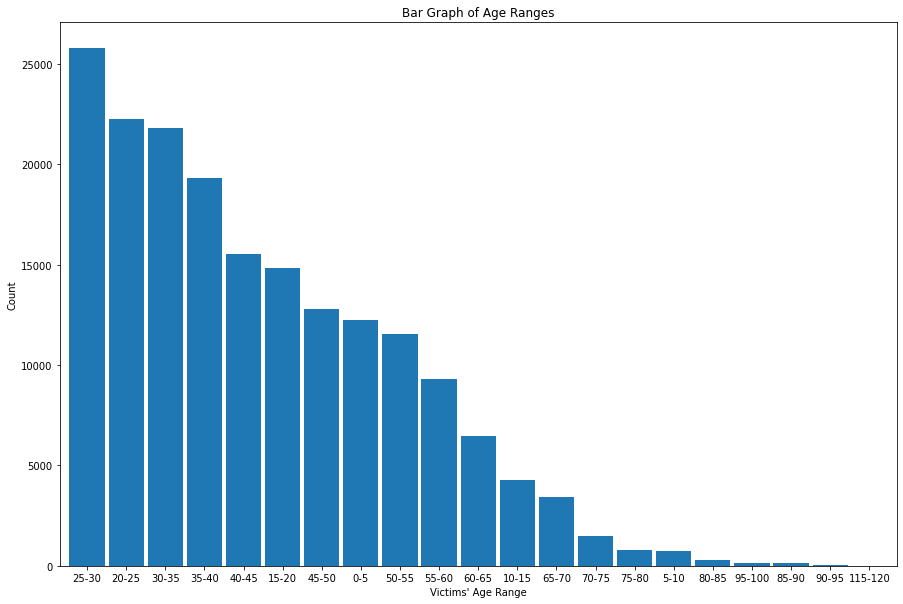

In [8]:
# this bar_plot library was created as a bar_plot.py file during the EDA Phase I
# stage; it can be acccessed in that respective notebook
from functions import bar_plot
bar_plot(15, 10, df, False, 'bar', 'Bar Graph of Age Ranges', 0, 
         "Victims' Age Range", 'Count', 'age_bin', 100)
plt.savefig(eda_image_path + '/age_range_bargraph.png', bbox_inches = 'tight')

## Contingency Table

A function for populating a contingency table is created such that it can be used with the variables of interest and the target column. 

In [9]:
def cont_table(df, col1, lev1, col2, lev2):
    '''
    Inputs:
        df: dataframe to ingest for the contingency table
        col1: column of interest from the dataframe; more often than not this 
              is the ground truth (target) column - but this can be replaced
              with any binary outcome column
        col2: column that the dataframe is being grouped by
        lev1: if using ground truth column, these are the less severe crimes
        lev2: if using ground truth column, these are the more severe crimes
    Outputs:
        crime_res_comb.style.format("{:,.0f}"): returns the contingency table
        as a dataframe with values formatted to two decimal places        
    '''
    crime_less = df.loc[df[col1]==lev1].groupby([col2])[[col1]].count()
    crime_less.rename(columns = {col1:lev1}, inplace=True)
    crime_more = df.loc[df[col1]==lev2].groupby([col2])[[col1]].count()
    crime_more.rename(columns={col1:lev2}, inplace=True)
    crime_res_comb = pd.concat([crime_less, crime_more], axis=1)

    # sum row totals
    crime_res_comb['Total']=crime_res_comb.sum(axis=1)
    crime_res_comb.loc['Total']=crime_res_comb.sum(numeric_only=True, axis=0)
    # get % total of each row
    crime_res_comb['% More Serious']=round((crime_res_comb[lev2] / 
    (crime_res_comb[lev2]+crime_res_comb[lev1]))*100, 2)
    crime_res_comb[lev2]=crime_res_comb[lev2].fillna(0)
    crime_res_comb['% More Serious']=crime_res_comb['% More Serious'].fillna(0)
    # crime_res_comb.set_index('new_index_name')

    return crime_res_comb.style.format("{:,.0f}")

## Summary Statistics

In [10]:
def summ_stats(df, var1, var2):
    print("\033[1m"+'Summary Statistics by Age'+"\033[1m")
    pd.options.display.float_format = '{:,.2f}'.format
    summ_stats = df.groupby(var1)[var2].agg(['mean', 'median', 'std', 'min', 'max'])
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = summ_stats.rename(columns = column_rename)
    return dfsummary

### Status Description by Age

In [11]:
summ_stats(df, 'Status_Desc', 'Vict_Age')

Summary Statistics by Age


,Mean,Median,Standard Deviation,Minimum,Maximum
Status_Desc,,,,,
Adult Arrest,33.00,32.00,17.85,0.00,99.00
Adult Other,35.69,34.00,15.24,0.00,99.00
Invest Cont,34.64,33.00,16.96,0.00,120.00
Juv Arrest,26.26,23.00,16.39,0.00,81.00
Juv Other,23.35,17.00,16.01,0.00,76.00


### Victim Sex by Age

Table 1 shows that the average age of male victims is approximately 36 years old, whereas the mean age of female victims is approximately 34 years old, with the means presenting greater age values than the medians (positively skewed distributions for both). Unknown genders show a mean age of approximately six years old and a median of 0 (newborns or infants). 

In [12]:
summ_stats(df, 'Victim_Sex', 'Vict_Age')

Summary Statistics by Age


,Mean,Median,Standard Deviation,Minimum,Maximum
Victim_Sex,,,,,
F,34.44,32.00,15.19,0.00,99.00
M,36.32,35.00,16.46,0.00,99.00
X,5.69,0.00,12.95,0.00,120.00


## Stacked Bar Plots

In [13]:
def stacked_plot (x, y, p, df, col, truth, condition, kind, title1, xlabel1, 
                  ylabel1, width, rot, title2, xlabel2, ylabel2):
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(x, y))
    flat = axes.flatten()
    fig.tight_layout(w_pad=5, pad=p, h_pad=5)
    flat = axes.flatten()
    fig.suptitle('Absolute Distributions vs. Normalized Distributions')

    crosstabdest = pd.crosstab(df[col], df[truth])\
                  .sort_values(by=[condition], ascending=False)
    crosstabdestnorm = crosstabdest.div(crosstabdest.sum(1), axis = 0)

    plotdest = crosstabdest.plot(kind=kind, stacked=True, title=title1, 
                                  ax=flat[0], 
                                  color=['#00BFC4', '#F8766D'], width=width, 
                                  rot=rot)
    flat[0].set_xlabel(xlabel1)
    flat[0].set_ylabel(ylabel1)
    plotdestnorm = crosstabdestnorm.plot(kind=kind, stacked=True, title=title2,
                                          ylabel='Frequency', 
                                          ax=flat[1], color=['#00BFC4', 
                                                             '#F8766D'], 
                                          width=width, rot=rot)
    flat[1].set_xlabel(xlabel2)
    flat[1].set_ylabel(ylabel2)
    plt.xlabel(xlabel2)

### Crime Severity by Age Group

Crime severity presents at an about even ratio per age group, with the exception being the highest age range of 115-120, where crime incidence is lower, but overall, more serious. Moreover, it is interesting to note that there are 19,073 more serious crimes than less serious ones, comprising an overwhelming majority (55.56%) of all cases.

In [14]:
age_table = cont_table(df, 'crime_severity', 'Less Serious', 'age_bin', 
                       'More Serious').data
age_table

,Less Serious,More Serious,Total,% More Serious
age_bin,,,,
0-5,"6,731.00","5,516.00","12,247.00",45.04
10-15,"2,329.00","1,932.00","4,261.00",45.34
15-20,"6,348.00","8,465.00","14,813.00",57.15
20-25,"9,697.00","12,538.00","22,235.00",56.39
25-30,"10,975.00","14,817.00","25,792.00",57.45
30-35,"9,708.00","12,093.00","21,801.00",55.47
35-40,"8,583.00","10,716.00","19,299.00",55.53
40-45,"6,744.00","8,802.00","15,546.00",56.62
45-50,"5,802.00","6,975.00","12,777.00",54.59


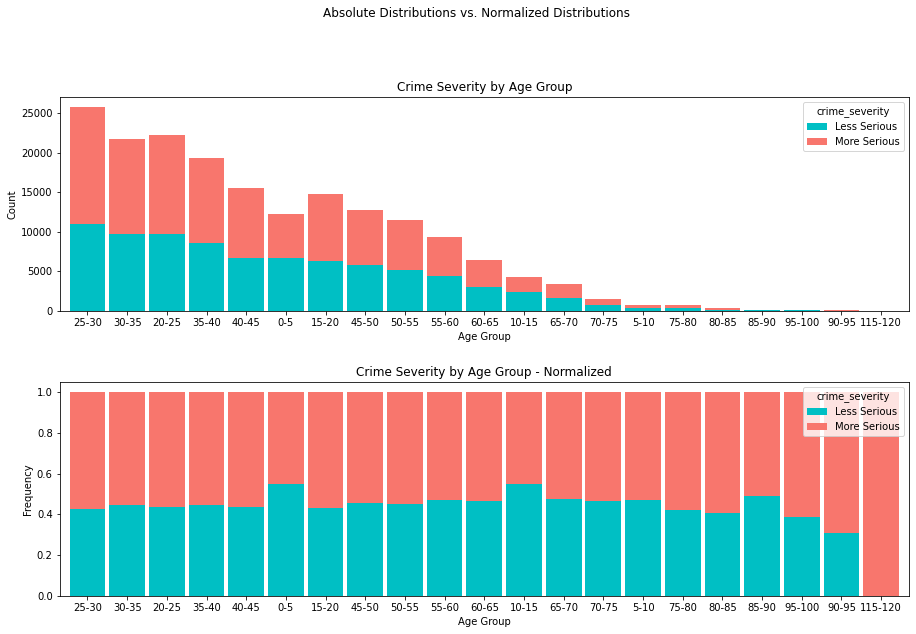

In [15]:
stacked_plot(15, 10, 10, df, 'age_bin', 'crime_severity', 'Less Serious', 'bar', 
             'Crime Severity by Age Group', 'Age Group', 'Count', 0.9, 0,
             'Crime Severity by Age Group - Normalized', 'Age Group', 
             'Frequency')
plt.savefig(eda_image_path + '/age_crime_bargraph.png', bbox_inches='tight')

### Crime Severity by Street Type

It is interesting to note that not only the least serious crimes occur in alleys, pedestrian walkways, private roads (paved or unpaved), and trails, but that where they do occur, they are less severe.

In [16]:
street_type_table = cont_table(df, 'crime_severity', 'Less Serious', 
                               'Type', 'More Serious').data
street_type_table 

,Less Serious,More Serious,Total,% More Serious
Type,,,,
Alley,240.00,190.00,430.00,44.19
Minor,"41,420.00","49,066.00","90,486.00",54.22
Pedestrian Walkway,211.00,49.00,260.00,18.85
Primary,"29,291.00","35,953.00","65,244.00",55.11
Private Road,31.00,38.00,69.00,55.07
Secondary,"11,562.00","15,077.00","26,639.00",56.60
Trail,15.00,6.00,21.00,28.57
Unpaved Road,NaN,2.00,2.00,0.00
Total,"82,770.00","100,381.00","183,151.00",54.81


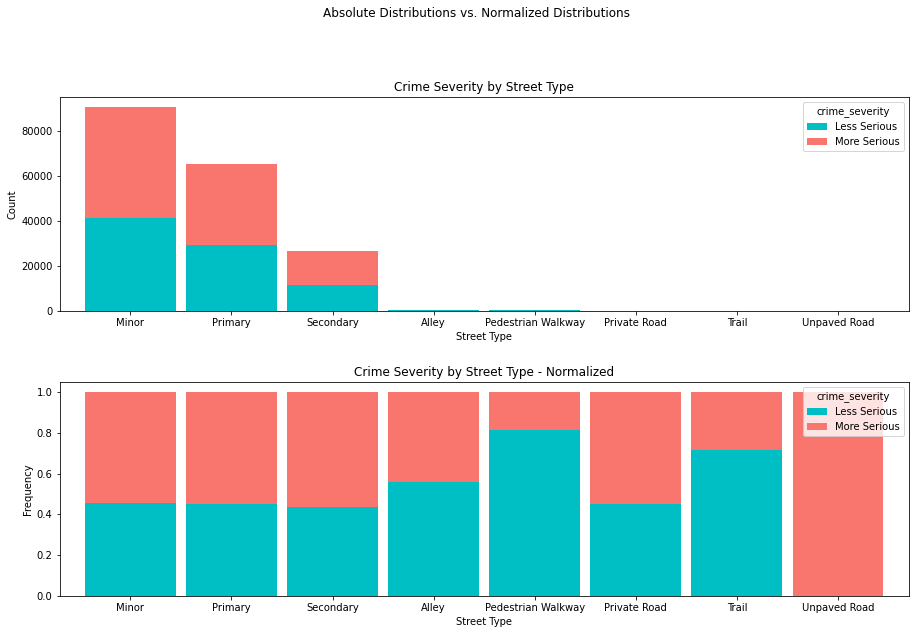

In [17]:
stacked_plot(15, 10, 10, df, 'Type', 'crime_severity', 'Less Serious', 'bar', 
             'Crime Severity by Street Type', 'Street Type', 'Count', 0.9, 0, 
             'Crime Severity by Street Type - Normalized', 'Street Type',
             'Frequency')
plt.savefig(eda_image_path + '/street_type_bargraph.png', bbox_inches='tight')


### Crime Severity by Gender

Whereas there are more males than females in this dataset, it can be seen from both the regular and normalized distributions, respectively, that more serious crimes occur with a higher prevalence  (69,370 or 64.24%) for the former than the latter (28,565 or 41.70%). For genders unknown, there is a 36.70% prevalence rate for more serious crimes. 

In [18]:
sex_table = cont_table(df, 'crime_severity', 'Less Serious', 'Victim_Sex', 
                       'More Serious').data
sex_table

,Less Serious,More Serious,Total,% More Serious
Victim_Sex,,,,
F,39936,28565,68501,41.70
M,38615,69370,107985,64.24
X,4219,2446,6665,36.70
Total,82770,100381,183151,54.81


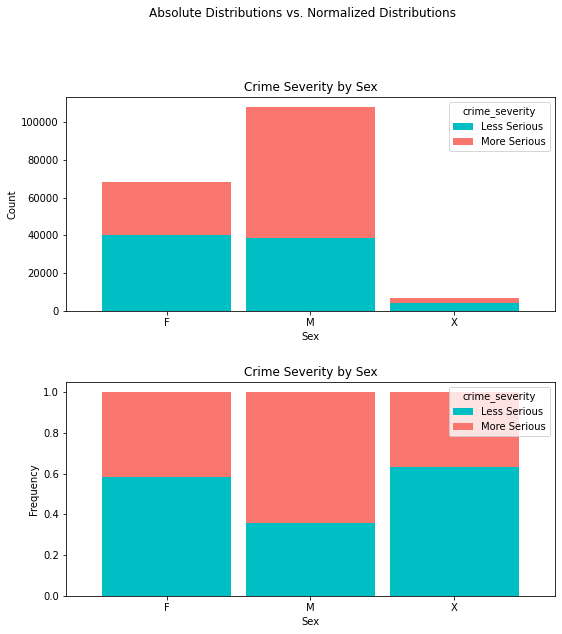

In [19]:
stacked_plot(10, 10, 10, df, 'Victim_Sex', 'crime_severity', 'Less Serious', 
             'bar', 'Crime Severity by Sex', 'Sex', 'Count', 
             0.9, 0, 'Crime Severity by Sex', 'Sex', 'Frequency')
plt.savefig(eda_image_path + '/victim_sex_bargraph.png', bbox_inches='tight')

### Crime Severity by Time of Day

It is interesting to note that more serious crimes (35,396) occur in the morning than any other time of day, with more serious night crimes accounting for only 9,814 (approximately 10%) of all such crimes.

In [20]:
time_table = cont_table(df, 'crime_severity', 'Less Serious', 
                        'Time_of_Day', 'More Serious').data
time_table 

,Less Serious,More Serious,Total,% More Serious
Time_of_Day,,,,
Afternoon,29609,31406,61015,51.47
Evening,18547,23765,42312,56.17
Morning,28105,35396,63501,55.74
Night,6509,9814,16323,60.12
Total,82770,100381,183151,54.81


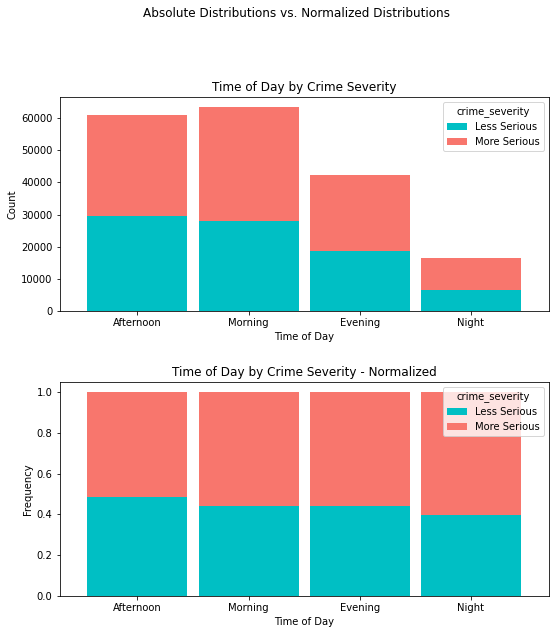

In [21]:
stacked_plot(10, 10, 10, df, 'Time_of_Day', 'crime_severity', 'Less Serious', 
             'bar', "Time of Day by Crime Severity", 'Time of Day', 'Count', 
             0.9, 0, 'Time of Day by Crime Severity - Normalized', 
             'Time of Day', 'Frequency')
plt.savefig(eda_image_path + '/time_of_day_bargraph.png', bbox_inches='tight')

### Crime Severity by Month

The month of June presents a record of 10,852 more serious crimes than any other month, so there exists a higher prevalence of more serious crimes mid-year than any other time of year.

In [22]:
month_table = cont_table(df, 'crime_severity', 'Less Serious', 
                         'Month', 'More Serious').data
month_table 

,Less Serious,More Serious,Total,% More Serious
Month,,,,
April,8165,9530,17695,53.86
August,6002,7468,13470,55.44
December,4241,5843,10084,57.94
February,7960,9114,17074,53.38
January,8376,9457,17833,53.03
July,6690,8404,15094,55.68
June,8756,10852,19608,55.34
March,8092,9216,17308,53.25
May,8841,10548,19389,54.40


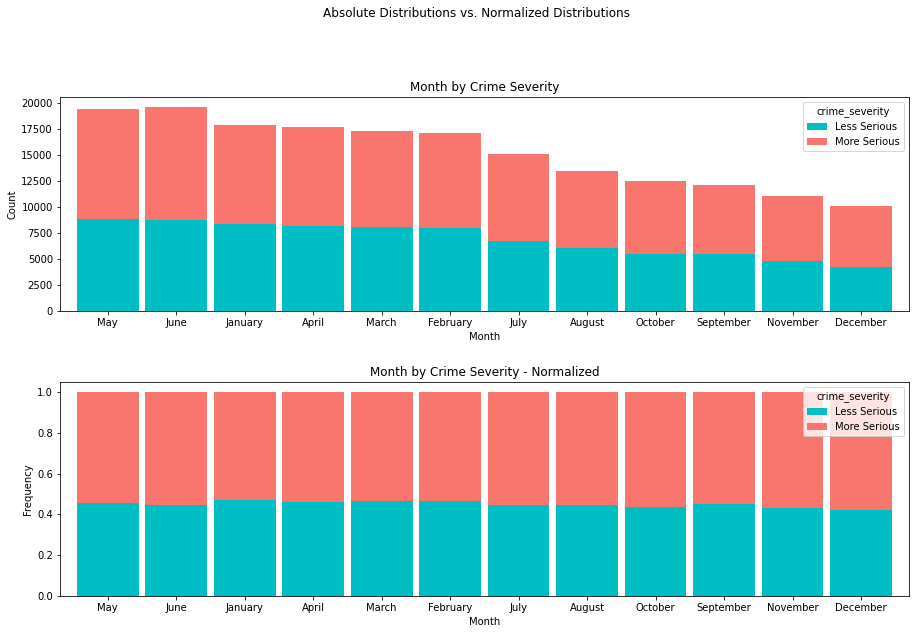

In [23]:
stacked_plot(15, 10, 10, df, 'Month', 'crime_severity', 'Less Serious', 
             'bar', 'Month by Crime Severity', 'Month', 'Count', 
             0.9, 0, 'Month by Crime Severity - Normalized', 
             'Month', 'Frequency')
plt.savefig(eda_image_path + '/month_bargraph.png', bbox_inches='tight')

### Crime Severity Victim Descent

In terms of ethnicity, members of the Hispanic/Latin/Mexican demographic account for 51,601 incidences of more serious crimes. More importantly, with an additional 40,226 less serious crimes, this demographic accounts for a total of 91,827 crimes, an overwhelming 50% of all crimes in the data.

In [24]:
descent_table = cont_table(df, 'crime_severity', 'Less Serious', 
                           'Victim_Desc', 'More Serious').data
descent_table

,Less Serious,More Serious,Total,% More Serious
Victim_Desc,,,,
American Indian/Alaskan Native,28.00,16.00,44.00,36.36
Black,"16,598.00","26,092.00","42,690.00",61.12
Filipino,23.00,33.00,56.00,58.93
Guamanian,16.00,4.00,20.00,20.00
Hispanic/Latin/Mexican,"40,226.00","51,601.00","91,827.00",56.19
Japanese,5.00,9.00,14.00,64.29
Korean,129.00,162.00,291.00,55.67
Other,"5,043.00","4,877.00","9,920.00",49.16
Other Asian,"1,485.00","1,541.00","3,026.00",50.93


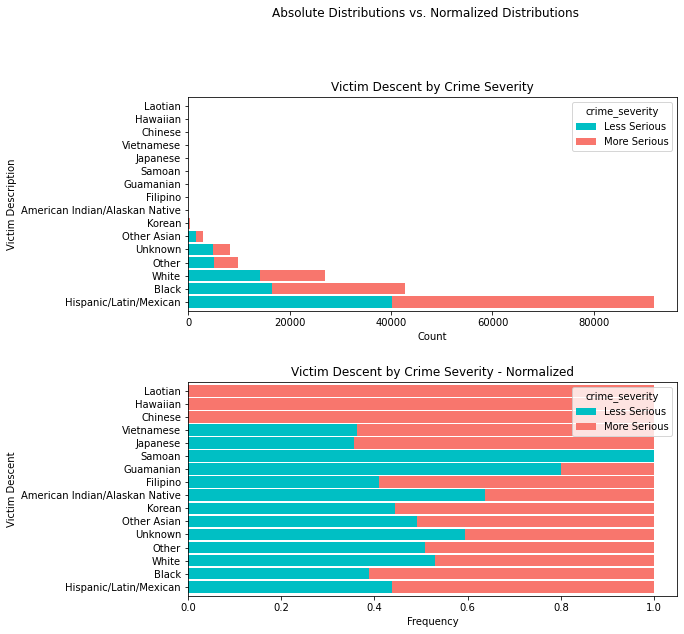

In [ ]:
stacked_plot(10,10, 10, df, 'Victim_Desc', 'crime_severity', 'Less Serious', 
             'barh', 'Victim Descent by Crime Severity', 'Count', 
             'Victim Description', 0.9, 0, 
             'Victim Descent by Crime Severity - Normalized', 
             'Frequency', 'Victim Descent')
plt.savefig(eda_image_path + '/victim_desc_bargraph.png', bbox_inches='tight')

### Crime Severity by Neighborhood

In terms of neighborhoods based on police districts, the 77th Street region shows the highest amount of more serious crimes (14,350) than any other district; second is the Southeast area (10,142).

In [ ]:
area_table = cont_table(df, 'crime_severity', 'Less Serious', 
                        'AREA_NAME', 'More Serious').data
area_table 

In [ ]:
stacked_plot(10, 10, 10, df, 'AREA_NAME', 'crime_severity', 'Less Serious', 
             'barh', 'Neighborhood by Crime Severity', 'Count', 'Neighborhood', 
             0.9, 0, 'Neighborhood by Crime Severity - Normalized', 'Frequency', 
             'Neighborhood')
plt.savefig(eda_image_path + '/neighborhood_bargraph.png', bbox_inches='tight')

### Crime Severity by Premises

It is equally important to note that most crimes (100,487 or ~55%) occur on the street, with 57.51% being attributed to more serious crimes.

In [ ]:
premis_table = cont_table(df, 'crime_severity', 'Less Serious', 
                          'Premises', 'More Serious').data
premis_table 

In [ ]:
stacked_plot(10, 10, 10, df, 'Premises', 'crime_severity', 'Less Serious', 'barh', 
             'Premises by Crime Severity', 'Count', 'Premises', 0.9, 0, 
             'Premises by Crime Severity - Normalized', 'Frequency', 
             'Premises')
plt.savefig(eda_image_path + '/premises_bargraph.png', bbox_inches='tight')

### Histogram Distributions Colored by Crime Code Target

In [ ]:
train_set = pd.read_csv(train_path).set_index('OBJECTID')

In [ ]:
def colored_hist(target, nrows, ncols, x, y, w_pad, h_pad):
    # create empty list to enumerate columns from
    list1 = train_set.drop(columns={target})
    # set the plot size dimensions
    fig, axes = plt.subplots(nrows, ncols, figsize=(x, y))
    ax = axes.flatten()
    for i, col in enumerate(list1):
        train_set.pivot(columns=target)[col].plot(kind='hist', density=True, 
                                                        stacked=True, ax=ax[i])
        ax[i].set_title(col)
        ax[i].set_xlabel('Values')
        ax[i].legend(loc='upper right')
        
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)

In [ ]:
colored_hist('Crime_Code', 5, 7, 25, 20, 6, 12)
plt.savefig(eda_image_path + '/colored_hist.png', bbox_inches='tight')

## Examining Possible Correlations

In [ ]:
def corr_plot(df, x, y):
    # correlation matrix title
    print("\033[1m"+'La Crime Data: Correlation Matrix'+"\033[1m")
    # assign correlation function to new variable
    corr = df.corr()
    matrix = np.triu(corr) # for triangular matrix
    plt.figure(figsize=(x,y))
    # parse corr variable intro triangular matrix
    sns.heatmap(df.corr(method='pearson'), 
                annot=True, linewidths=.5, cmap='coolwarm', mask=matrix,
                square = True, 
                cbar_kws={'label': 'Correlation Index'})
  

In [ ]:
corr_df = train_set.reset_index(drop=True)
# corr_df = corr_df.drop(columns='OBJECTID')

In [ ]:
corr_plot(corr_df, 25, 25)
plt.savefig(eda_image_path + '/correlation_plot.png', bbox_inches='tight')